In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize
import random
import keras
from keras import backend as K
from keras.utils import plot_model
from keras.datasets import cifar10
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, Callback

%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load and Preprocessing the CIFAR10 Dataset

In [2]:
# Create label and digit map
digit2labels = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 
                5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
label2digits = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 
                'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

In [3]:
# Download the CIFAR10 dataset from Kaggle: https://www.kaggle.com/c/cifar-10
# Unzip the download data train.7z and test.7z such that 
# training images is in ./data/train/ and test images are in ./data/test/

preprocessing = False  # whether or not to read the images and save to numpy array
if preprocessing is True:
    train_label = pd.read_csv('./data/trainLabels.csv')['label'].values
    test_label = pd.read_csv('./data/sampleSubmission.csv')
    
    # process the training set, totally 50,000 images
    train_x = []
    train_y = []
    num = 50000
    for i in range(num):
        img = imread('./data/train/{0:d}.png'.format(i + 1))
        label = train_label[i]
        train_x.append(img)
        train_y.append(label)
        
    # process the test set, totally 300,000 images
    test_x = []
    num = 300000
    for i in range(num):
        img = imread('./data/test/{0:d}.png'.format(i + 1))
        test_x.append(img)
        
    # Transform to numpy array
    train_x = np.array(train_x, dtype='uint8')
    train_y = np.array(list(map(lambda x: label2digits[x], train_y))).reshape((-1, 1))
    test_x = np.array(test_x, dtype='uint8')

    # Save to disk
    np.save('./data/train_x.npy', train_x)
    np.save('./data/train_y.npy', train_y)
    np.save('./data/test_x.npy', test_x)

In [4]:
# Load CIFAR10 dataset instead of using the data from Kaggle
(train_x, train_y), (val_x, val_y) = cifar10.load_data()

# Resize the image size to be (48, 48, 3)
train_x = np.array([resize(img, (48, 48, 3)) for img in train_x])
val_x = np.array([resize(img, (48, 48, 3)) for img in val_x])

# Convert class vectors to binary class matrices
train_y = keras.utils.to_categorical(train_y, 10)
val_y = keras.utils.to_categorical(val_y, 10)

# Get the info about the dataset
print('Train:\t\t', train_x.shape, val_y.shape)
print('Valdation:\t', val_x.shape, val_y.shape)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Train:		 (50000, 48, 48, 3) (10000, 10)
Valdation:	 (10000, 48, 48, 3) (10000, 10)


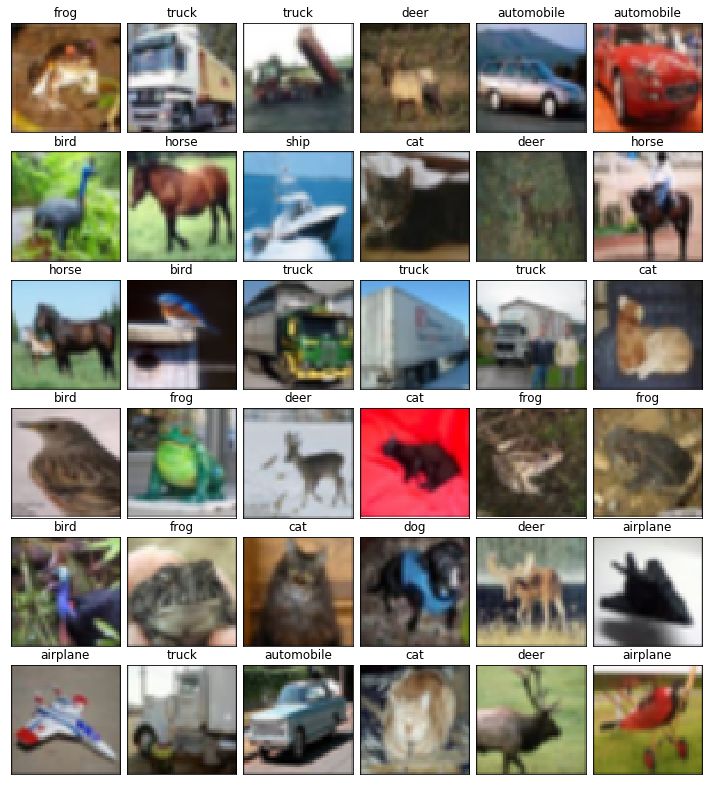

In [5]:
# Visualize the CIFAR10 dataset
nrows, ncols = 6, 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 11))
for row in range(nrows):
    for col in range(ncols):
        idx = row * ncols + col
        ax[row][col].imshow(train_x[idx])
        ax[row][col].set_title(digit2labels[np.argmax(train_y[idx])])
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
plt.tight_layout(h_pad=0, w_pad=0)
fig.savefig('./result/snapshot.png', dpi=200)
plt.show()

# Build VGG19 Model

VGG-19 is a easy-to-understand CNN model built for ImageNet recognition. Here, the model is re-built based on the original paper [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)

In [9]:
def VGG19(input_shape=(32, 32, 3), classes=10):
    """ Define VGG19 model using Keras API """
    model = Sequential(name='VGG19')
    # Block # 1
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block1_conv1'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block1_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='block1_pool'))
    
    # Block # 2
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block2_conv1'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block2_conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='block2_pool'))
    
    # Block # 3
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block3_conv1'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block3_conv2'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block3_conv3'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block3_conv4'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='block3_pool'))
    
    # Block # 4
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block4_conv1'))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block4_conv2'))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block4_conv3'))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block4_conv4'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='block4_pool'))
    
    # Block # 5
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block5_conv1'))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block5_conv2'))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block5_conv3'))
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', 
                     input_shape=input_shape, name='block5_conv4'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name='block5_pool'))
    
    # Fully connected layers
    model.add(Flatten(name='flatten'))
    model.add(Dense(units=256, activation='relu', name='fc1'))
    model.add(Dense(units=128, activation='relu', name='fc2'))
    model.add(Dense(units=classes, activation='softmax', name='prediction'))
    
    return model

In [12]:
# To reproduce the result, refer to https://keras.io/getting-started/faq/
np.random.seed(42)
random.seed(42)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(42)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [13]:
# Create VGG-19 model
input_shape = (48, 48, 3)
vgg19 = VGG19(input_shape=input_shape, classes=10)

vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 12, 12, 256)       295168    
__________

In [22]:
# Create optimizer
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Create call backs
checkpoint = ModelCheckpoint(filepath='./models/vgg19_checkpoint.h5', verbose=0, save_best_only=True)

# Train the model
vgg19_history = vgg19.fit(x=train_x, y=train_y, batch_size=64, epochs=200, verbose=2, 
                          validation_data=(val_x, val_y), callbacks=[checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
 - 29s - loss: 2.3027 - acc: 0.0976 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/200
 - 28s - loss: 2.3027 - acc: 0.0956 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 3/200
 - 28s - loss: 2.3027 - acc: 0.0984 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/200
 - 28s - loss: 2.3027 - acc: 0.0996 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 5/200
 - 28s - loss: 2.3028 - acc: 0.0968 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 6/200
 - 28s - loss: 2.3027 - acc: 0.0964 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 7/200


KeyboardInterrupt: 

In [ ]:
# Save models
vgg19.save('./models/vgg19_model.h5')

# Using Pre-trained VGG19 Model

In [ ]:
# Import pre-trained VGG19 on ImageNet dataset
vgg19_pretrain = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)